# Описание проекта

Вы аналитик компании «Мегалайн» — федерального оператора сотовой связи. Клиентам предлагают два тарифных плана: «Смарт» и «Ультра». Чтобы скорректировать рекламный бюджет, коммерческий департамент хочет понять, какой тариф приносит больше денег.
Вам предстоит сделать предварительный анализ тарифов на небольшой выборке клиентов. 


Описание тарифов
Тариф «Смарт»
Ежемесячная плата: 550 рублей
Включено 500 минут разговора, 50 сообщений и 15 Гб интернет-трафика
Стоимость услуг сверх тарифного пакета:
минута разговора: 3 рубля
сообщение: 3 рубля
1 Гб интернет-трафика: 200 рублей

Тариф «Ультра»
Ежемесячная плата: 1950 рублей
Включено 3000 минут разговора, 1000 сообщений и 30 Гб интернет-трафика
Стоимость услуг сверх тарифного пакета:
минута разговора: 1 рубль
сообщение: 1 рубль
1 Гб интернет-трафика: 150 рублей

В вашем распоряжении данные 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше.

# Шаг 1. Откройте файл с данными и изучите общую информацию. 

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats as st
from scipy.stats import mannwhitneyu

import sys
import warnings
if not sys.warnoptions:
       warnings.simplefilter("ignore")

In [2]:
data_calls = pd.read_csv('/1/calls.csv')
data_internet = pd.read_csv('/1/internet.csv')
data_messages = pd.read_csv('/1/messages.csv')
data_tariffs = pd.read_csv('/1/tariffs.csv')
data_users = pd.read_csv('/1/users.csv')

## Таблица с данными о звонках

In [3]:
data_calls

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000
...,...,...,...,...
202602,1499_215,2018-12-26,0.76,1499
202603,1499_216,2018-10-18,18.83,1499
202604,1499_217,2018-11-10,10.81,1499
202605,1499_218,2018-10-06,4.27,1499


In [4]:
data_calls.describe()

,duration,user_id
count,202607.000000,202607.000000
mean,6.755887,1253.940619
std,5.843365,144.722751
min,0.000000,1000.000000
25%,1.300000,1126.000000
50%,6.000000,1260.000000
75%,10.700000,1379.000000
max,38.000000,1499.000000


In [5]:
data_calls.duplicated().sum()

0

In [6]:
data_calls[data_calls['duration'] == 0].count()

id           39613
call_date    39613
duration     39613
user_id      39613
dtype: int64

In [7]:
data_calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         202607 non-null  object 
 1   call_date  202607 non-null  object 
 2   duration   202607 non-null  float64
 3   user_id    202607 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


Средняя продолжительность звонка 6 минут - правдоподобно, около 20% звонков с 0 минут - это пропущенные вызовы или брак в данных? Нужно разбираться.

Данные в столбце call_date нужно перевести в формат даты.

## Таблица с данными о заходах в Интернет

In [8]:
data_internet.head(10)

,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000
5,5,1000_5,399.97,2018-10-02,1000
6,6,1000_6,540.08,2018-09-07,1000
7,7,1000_7,415.70,2018-07-11,1000
8,8,1000_8,505.40,2018-10-08,1000
9,9,1000_9,345.54,2018-09-03,1000


In [9]:
data_internet.describe()

,Unnamed: 0,mb_used,user_id
count,149396.000000,149396.000000,149396.000000
mean,74697.500000,370.192426,1252.099842
std,43127.054745,278.300951,144.050823
min,0.000000,0.000000,1000.000000
25%,37348.750000,138.187500,1130.000000
50%,74697.500000,348.015000,1251.000000
75%,112046.250000,559.552500,1380.000000
max,149395.000000,1724.830000,1499.000000


In [10]:
data_internet.duplicated().sum()

0

In [11]:
data_internet[data_internet['mb_used'] == 0]

,Unnamed: 0,id,mb_used,session_date,user_id
11,11,1000_11,0.0,2018-08-28,1000
38,38,1000_38,0.0,2018-11-27,1000
46,46,1000_46,0.0,2018-06-30,1000
67,67,1000_67,0.0,2018-06-16,1000
72,72,1000_72,0.0,2018-06-15,1000
...,...,...,...,...,...
149380,149380,1499_141,0.0,2018-12-11,1499
149381,149381,1499_142,0.0,2018-11-01,1499
149383,149383,1499_144,0.0,2018-11-27,1499
149386,149386,1499_147,0.0,2018-10-21,1499


In [12]:
data_internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Unnamed: 0    149396 non-null  int64  
 1   id            149396 non-null  object 
 2   mb_used       149396 non-null  float64
 3   session_date  149396 non-null  object 
 4   user_id       149396 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB


Заметил, что в столбце mb_used есть 0 значения, то же самое встречалось и в таблице data_calls. Гипотеза та же - возможно люди просто не пользовались интернетом.

В столбце 'session_date' нужно заменить значения на другой тип данных.

Есть столбец Unnamed:0, про который ничего не говорилось на главной странице - значит его можно удалить.

## Таблица с данными об смс сообщениях

In [13]:
data_messages.head(10)

,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000
5,1000_5,2018-06-20,1000
6,1000_6,2018-11-19,1000
7,1000_7,2018-10-29,1000
8,1000_8,2018-06-25,1000
9,1000_9,2018-12-18,1000


In [14]:
data_messages.describe()

,user_id
count,123036.000000
mean,1256.989410
std,143.523967
min,1000.000000
25%,1134.000000
50%,1271.000000
75%,1381.000000
max,1499.000000


In [15]:
data_messages.duplicated().sum()

0

In [16]:
data_messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            123036 non-null  object
 1   message_date  123036 non-null  object
 2   user_id       123036 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


В столбце 'message_date' нужно заменить значения на другой тип данных.

## Таблица с подробными данными о пользователях

In [17]:
data_users.head(10)

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra
5,1005,67,NaN,Набережные Челны,Афанасий,Горлов,2018-01-25,smart
6,1006,21,NaN,Ульяновск,Леонид,Ермолаев,2018-02-26,smart
7,1007,65,NaN,Москва,Юна,Березина,2018-04-19,smart
8,1008,63,NaN,Челябинск,Рустэм,Пономарёв,2018-12-19,smart
9,1009,24,NaN,Пермь,Василиса,Блинова,2018-03-22,smart


In [18]:
data_users.describe()

,user_id,age
count,500.000000,500.00000
mean,1249.500000,46.58800
std,144.481833,16.66763
min,1000.000000,18.00000
25%,1124.750000,32.00000
50%,1249.500000,46.00000
75%,1374.250000,62.00000
max,1499.000000,75.00000


In [19]:
data_users.duplicated().sum()

0

In [20]:
data_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   age         500 non-null    int64 
 2   churn_date  38 non-null     object
 3   city        500 non-null    object
 4   first_name  500 non-null    object
 5   last_name   500 non-null    object
 6   reg_date    500 non-null    object
 7   tariff      500 non-null    object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


In [21]:
smart_tariff = data_users[data_users['tariff'] == 'smart']
ultra_tariff = data_users[data_users['tariff'] == 'ultra']

In [22]:
smart_tariff

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
5,1005,67,NaN,Набережные Челны,Афанасий,Горлов,2018-01-25,smart
6,1006,21,NaN,Ульяновск,Леонид,Ермолаев,2018-02-26,smart
7,1007,65,NaN,Москва,Юна,Березина,2018-04-19,smart
...,...,...,...,...,...,...,...,...
494,1494,62,NaN,Омск,Ренат,Андропов,2018-08-17,smart
496,1496,36,NaN,Вологда,Трифон,Блохин,2018-01-27,smart
497,1497,32,NaN,Челябинск,Каролина,Агеева,2018-10-09,smart
498,1498,68,2018-10-25,Владикавказ,Всеволод,Акимчин,2018-07-19,smart


In [23]:
ultra_tariff

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra
13,1013,36,NaN,Иваново,Борис,Андреенко,2018-11-14,ultra
16,1016,58,NaN,Омск,Марица,Сазонова,2018-11-21,ultra
...,...,...,...,...,...,...,...,...
476,1476,50,NaN,Москва,Валентина,Семенова,2018-04-30,ultra
485,1485,34,NaN,Киров,Таисия,Сухова,2018-12-29,ultra
491,1491,56,NaN,Челябинск,Радислав,Андрейкин,2018-04-25,ultra
493,1493,71,NaN,Красноярск,Таисия,Ахматулина,2018-11-24,ultra


В столбце 'churn_date' много пропусков. Скорее всего они вызваны тем, что большая часть людей не меняла тариф.

В столбце 'reg_date' нужно заменить значения на другой тип данных.

## Таблица с данными о тарифах

In [24]:
data_tariffs.head(10)

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


In [25]:
data_tariffs.describe()

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute
count,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000
mean,525.000000,23040.000000,1750.000000,1250.000000,175.000000,2.000000,2.000000
std,671.751442,10861.160159,1767.766953,989.949494,35.355339,1.414214,1.414214
min,50.000000,15360.000000,500.000000,550.000000,150.000000,1.000000,1.000000
25%,287.500000,19200.000000,1125.000000,900.000000,162.500000,1.500000,1.500000
50%,525.000000,23040.000000,1750.000000,1250.000000,175.000000,2.000000,2.000000
75%,762.500000,26880.000000,2375.000000,1600.000000,187.500000,2.500000,2.500000
max,1000.000000,30720.000000,3000.000000,1950.000000,200.000000,3.000000,3.000000


In [26]:
data_tariffs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   messages_included      2 non-null      int64 
 1   mb_per_month_included  2 non-null      int64 
 2   minutes_included       2 non-null      int64 
 3   rub_monthly_fee        2 non-null      int64 
 4   rub_per_gb             2 non-null      int64 
 5   rub_per_message        2 non-null      int64 
 6   rub_per_minute         2 non-null      int64 
 7   tariff_name            2 non-null      object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


## Вывод


Данные в основном полные, пропусков мало и дубликатов нет.

Заметил, что в таблице 'data_calls' около 20% звонков с 0 минут; Нулевая гипотеза - это пропущенные вызовы, нужно разбираться.

Заметил, что в таблице 'data_internet' около 10% данных в столбце 'Mb_used' с 0 Mb; Нулевая гипотеза та же - возможно люди просто не пользовались интернетом.


В той же таблице есть столбец Unnamed, про который ничего не говорилось на главной странице - значит его можно удалить.


В столбцах 'message_date', 'reg_date', 'session_date', 'churn_date' и 'call_date' нужно заменить значения на другой тип данных.

В столбце 'churn_date' таблицы 'data_users' много пропусков, скорее всего они вызваны тем, что большая часть людей не меняла тариф. 

# Шаг 2. Предобработка данных


## Таблица с данными о звонках

Так как «Мегалайн» всегда округляет вверх значения минут, то нам нужно провести эту операцию.

In [27]:
data_calls['duration'] = data_calls['duration'].apply(np.ceil).astype('int')

Приведём значения в столбце 'call_date' в формат даты

In [28]:
data_calls['call_date'] = pd.to_datetime(data_calls['call_date'], format = '%Y-%m-%d')

Проверим гипотезу о звонках с 0 минут. Возможно, эти значения характерны для некоторых пользователей?

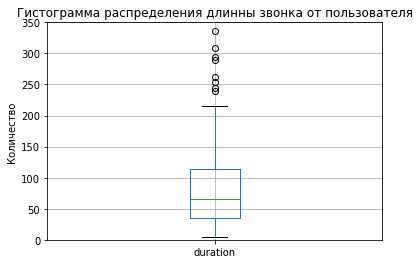

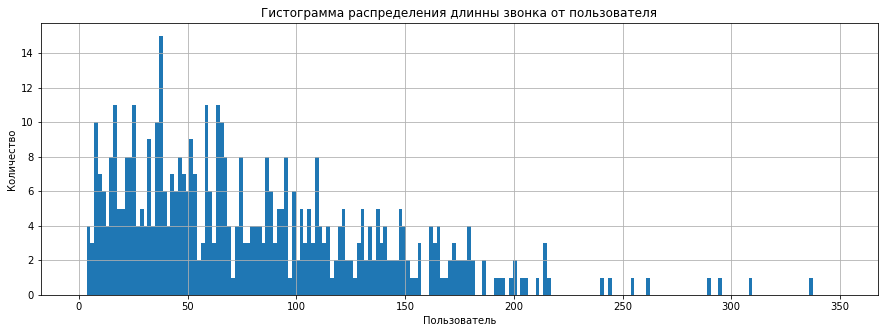

In [29]:
data_calls_zero = data_calls[data_calls['duration'] == 0].groupby('user_id').agg({'duration': 'count'})

data_calls_zero.boxplot(column = 'duration')
plt.ylim(0, 350)
plt.title('Гистограмма распределения длинны звонка от пользователя');
plt.ylabel('Количество');

data_calls_zero.hist('duration', bins=200, range = (0, 350), figsize = (15, 5)) 
plt.title('Гистограмма распределения длинны звонка от пользователя');
plt.xlabel('Пользователь');
plt.ylabel('Количество');

plt.show()

Гипотеза подтвердилась, я не вижу, чтобы такие звонки как-то странно распределялись.

Предлагаю создать новый датасет data_calls_fixed без подобных значений, к нему можно будет обратиться позже и посмотреть, как отсутствие этих данных повлияло на  полученные результаты.

In [30]:
data_calls_fixed = data_calls.drop(data_calls[data_calls['duration'] == 0].index).reset_index(drop=True)

## Таблица с данными о заходах в Интернет

Так как «Мегалайн» всегда округляет вверх значения Мб, то нам нужно провести эту операцию.

In [31]:
data_internet['mb_used'] = data_internet['mb_used'].apply(np.ceil).astype('int')

Приведём значения в столбце 'session_date' в формат даты

In [32]:
data_internet['session_date'] = pd.to_datetime(data_internet['session_date'], format = '%Y-%m-%d')

Удалим ненужный столбец в таблице data_internet

In [33]:
data_internet.drop(['Unnamed: 0'], axis = 1, inplace=True)

In [34]:
data_internet.head()

,id,mb_used,session_date,user_id
0,1000_0,113,2018-11-25,1000
1,1000_1,1053,2018-09-07,1000
2,1000_2,1198,2018-06-25,1000
3,1000_3,551,2018-08-22,1000
4,1000_4,303,2018-09-24,1000


Проверим гипотезу о неиспользованном трафике с 0 Мб. Возможно, эти значения характерны для некоторых пользователей?

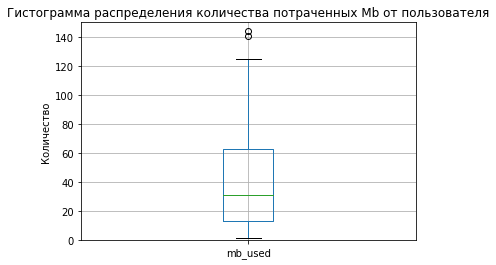

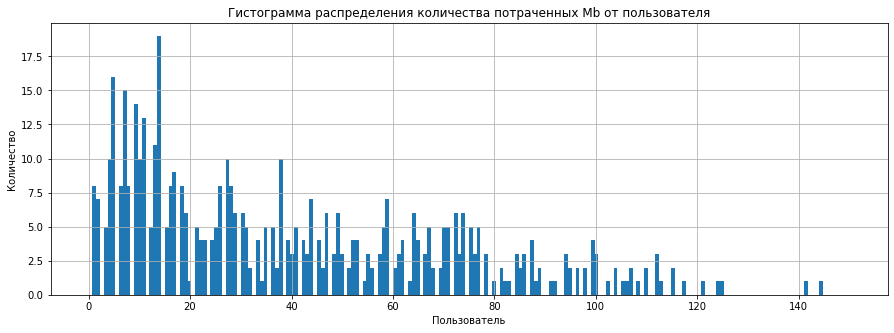

In [35]:
data_internet_zero = data_internet[data_internet['mb_used'] == 0].groupby('user_id').agg({'mb_used': 'count'})

data_internet_zero.boxplot(column = 'mb_used')
plt.ylim(0, 150)
plt.title('Гистограмма распределения количества потраченных Mb от пользователя');
plt.ylabel('Количество');

data_internet_zero.hist('mb_used', bins=200, range = (0, 150), figsize = (15, 5)) 
plt.title('Гистограмма распределения количества потраченных Mb от пользователя');
plt.xlabel('Пользователь');
plt.ylabel('Количество');

plt.show()

Гипотеза подтвердилась, поэтому я предлагаю создать новый датасет data_internet_fixed без подобных значений. Параллельно можно обращаться к базе данных data_internet и смотреть, как удаление повлияло на  полученные результаты.

In [36]:
data_internet_fixed = data_internet.drop(data_internet[data_internet['mb_used'] == 0].index).reset_index(drop=True)

## Таблица с данными об смс сообщениях

Приведём значения в столбце 'message_date' в формат даты

In [37]:
data_messages['message_date'] = pd.to_datetime(data_messages['message_date'], format = '%Y-%m-%d')

## Таблица с подробными данными о пользователях

Приведём значения в столбце 'reg_date' в формат даты

In [38]:
data_users['reg_date'] = pd.to_datetime(data_users['reg_date'], format = '%Y-%m-%d')
data_users['churn_date'] = pd.to_datetime(data_users['churn_date'], format = '%Y-%m-%d')

## Посчитайте для каждого пользователя:

### Количество сделанных звонков и израсходованных минут разговора по месяцам

#### Для таблицы с 0 значениями

In [39]:
data_calls

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0,1000
1,1000_1,2018-08-17,0,1000
2,1000_2,2018-06-11,3,1000
3,1000_3,2018-09-21,14,1000
4,1000_4,2018-12-15,6,1000
...,...,...,...,...
202602,1499_215,2018-12-26,1,1499
202603,1499_216,2018-10-18,19,1499
202604,1499_217,2018-11-10,11,1499
202605,1499_218,2018-10-06,5,1499


In [40]:
data_calls['month_name'] = data_calls['call_date'].dt.month_name()

In [41]:
data_calls['month'] = data_calls['call_date'].dt.month

In [42]:
made_calls_minutes = (
    data_calls.groupby(['user_id', 'month', 'month_name'])
        .agg({'duration': 'sum', 'id': 'count'})
        .reset_index()
        .rename(columns = {"id": "calls_made", "duration": "minutes_spent"})
)

made_calls_minutes

,user_id,month,month_name,minutes_spent,calls_made
0,1000,5,May,159,22
1,1000,6,June,172,43
2,1000,7,July,340,47
3,1000,8,August,408,52
4,1000,9,September,466,58
...,...,...,...,...,...
3169,1498,10,October,247,41
3170,1499,9,September,70,9
3171,1499,10,October,449,68
3172,1499,11,November,612,74


In [43]:
made_calls_minutes.describe()

,user_id,month,minutes_spent,calls_made
count,3174.000000,3174.000000,3174.000000,3174.000000
mean,1251.555766,8.311594,456.931632,63.833333
std,144.470630,2.910625,238.031270,32.678036
min,1000.000000,1.000000,0.000000,1.000000
25%,1126.000000,6.000000,290.000000,41.000000
50%,1254.000000,9.000000,447.000000,63.000000
75%,1378.000000,11.000000,592.000000,83.000000
max,1499.000000,12.000000,1673.000000,244.000000


#### Для таблицы без 0 значений

In [44]:
data_calls_fixed

,id,call_date,duration,user_id
0,1000_2,2018-06-11,3,1000
1,1000_3,2018-09-21,14,1000
2,1000_4,2018-12-15,6,1000
3,1000_7,2018-08-22,19,1000
4,1000_8,2018-09-15,19,1000
...,...,...,...,...
162989,1499_215,2018-12-26,1,1499
162990,1499_216,2018-10-18,19,1499
162991,1499_217,2018-11-10,11,1499
162992,1499_218,2018-10-06,5,1499


In [45]:
data_calls_fixed['month_name'] = data_calls_fixed['call_date'].dt.month_name()

In [46]:
data_calls_fixed['month'] = data_calls_fixed['call_date'].dt.month

In [47]:
made_calls_minutes_fixed = (
    data_calls_fixed.groupby(['user_id', 'month', 'month_name'])
        .agg({'duration': 'sum', 'id': 'count'})
        .reset_index()
        .rename(columns = {"id": "calls_made", "duration": "minutes_spent"})
)

made_calls_minutes_fixed

,user_id,month,month_name,minutes_spent,calls_made
0,1000,5,May,159,17
1,1000,6,June,172,28
2,1000,7,July,340,41
3,1000,8,August,408,42
4,1000,9,September,466,46
...,...,...,...,...,...
3163,1498,10,October,247,30
3164,1499,9,September,70,8
3165,1499,10,October,449,44
3166,1499,11,November,612,62


In [48]:
made_calls_minutes_fixed.describe()

,user_id,month,minutes_spent,calls_made
count,3168.000000,3168.000000,3168.000000,3168.000000
mean,1251.477588,8.317551,457.797033,51.450126
std,144.574946,2.907181,237.423514,26.439188
min,1000.000000,1.000000,1.000000,1.000000
25%,1126.000000,6.000000,290.750000,33.000000
50%,1254.000000,9.000000,447.500000,50.000000
75%,1379.000000,11.000000,592.250000,67.000000
max,1499.000000,12.000000,1673.000000,190.000000


Для каждого абонента было посчитано количество звонков, которые он сделал в месяц, а так же количество минут, которые он проговорил. Между двумя датасетами почти нет разницы.

### Объем израсходованного интернет-трафика по месяцам

#### Для таблицы с 0 значениями

In [49]:
data_internet['month'] = data_internet['session_date'].dt.month

In [50]:
data_internet['month_name'] = data_internet['session_date'].dt.month_name()

In [51]:
data_internet

,id,mb_used,session_date,user_id,month,month_name
0,1000_0,113,2018-11-25,1000,11,November
1,1000_1,1053,2018-09-07,1000,9,September
2,1000_2,1198,2018-06-25,1000,6,June
3,1000_3,551,2018-08-22,1000,8,August
4,1000_4,303,2018-09-24,1000,9,September
...,...,...,...,...,...,...
149391,1499_152,319,2018-10-03,1499,10,October
149392,1499_153,491,2018-12-14,1499,12,December
149393,1499_154,0,2018-10-27,1499,10,October
149394,1499_155,1247,2018-11-26,1499,11,November


In [52]:
made_internet_traffic = (
    data_internet.groupby(['user_id', 'month', 'month_name'])
        .agg({'mb_used': 'sum'})
        .reset_index()
        .rename(columns = {"mb_used": "Mb_spent"})
)

made_internet_traffic

,user_id,month,month_name,Mb_spent
0,1000,5,May,2256
1,1000,6,June,23257
2,1000,7,July,14016
3,1000,8,August,14070
4,1000,9,September,14581
...,...,...,...,...
3198,1498,10,October,20604
3199,1499,9,September,1848
3200,1499,10,October,17809
3201,1499,11,November,17984


In [53]:
made_internet_traffic.describe()

,user_id,month,Mb_spent
count,3203.000000,3203.000000,3203.000000
mean,1251.393069,8.320949,17286.749610
std,144.824407,2.903834,7523.580332
min,1000.000000,1.000000,0.000000
25%,1124.000000,6.000000,12543.000000
50%,1251.000000,9.000000,16985.000000
75%,1379.000000,11.000000,21455.500000
max,1499.000000,12.000000,49789.000000


#### Для таблицы без 0 значений

In [54]:
data_internet_fixed['month'] = data_internet_fixed['session_date'].dt.month

In [55]:
data_internet_fixed['month_name'] = data_internet_fixed['session_date'].dt.month_name()

In [56]:
data_internet_fixed

,id,mb_used,session_date,user_id,month,month_name
0,1000_0,113,2018-11-25,1000,11,November
1,1000_1,1053,2018-09-07,1000,9,September
2,1000_2,1198,2018-06-25,1000,6,June
3,1000_3,551,2018-08-22,1000,8,August
4,1000_4,303,2018-09-24,1000,9,September
...,...,...,...,...,...,...
129793,1499_151,753,2018-10-11,1499,10,October
129794,1499_152,319,2018-10-03,1499,10,October
129795,1499_153,491,2018-12-14,1499,12,December
129796,1499_155,1247,2018-11-26,1499,11,November


In [57]:
made_internet_traffic_fixed = (
    data_internet_fixed.groupby(['user_id', 'month', 'month_name'])
        .agg({'mb_used': 'sum'})
        .reset_index()
        .rename(columns = {"mb_used": "Mb_spent"})
)

made_internet_traffic_fixed

,user_id,month,month_name,Mb_spent
0,1000,5,May,2256
1,1000,6,June,23257
2,1000,7,July,14016
3,1000,8,August,14070
4,1000,9,September,14581
...,...,...,...,...
3196,1498,10,October,20604
3197,1499,9,September,1848
3198,1499,10,October,17809
3199,1499,11,November,17984


In [58]:
made_internet_traffic_fixed.describe()

,user_id,month,Mb_spent
count,3201.000000,3201.000000,3201.000000
mean,1251.406748,8.321462,17297.550453
std,144.829012,2.903996,7513.504652
min,1000.000000,1.000000,202.000000
25%,1124.000000,6.000000,12567.000000
50%,1251.000000,9.000000,16986.000000
75%,1379.000000,11.000000,21458.000000
max,1499.000000,12.000000,49789.000000


Для каждого абонента было посчитано количество Mb, которые он потратил в месяц. Между двумя датасетами почти нет разницы.

### Количество отправленных сообщений по месяцам

In [59]:
data_messages['month'] = data_messages['message_date'].dt.month

In [60]:
data_messages['month_name'] = data_messages['message_date'].dt.month_name()

In [61]:
data_messages

,id,message_date,user_id,month,month_name
0,1000_0,2018-06-27,1000,6,June
1,1000_1,2018-10-08,1000,10,October
2,1000_2,2018-08-04,1000,8,August
3,1000_3,2018-06-16,1000,6,June
4,1000_4,2018-12-05,1000,12,December
...,...,...,...,...,...
123031,1499_179,2018-12-12,1499,12,December
123032,1499_180,2018-09-28,1499,9,September
123033,1499_181,2018-09-27,1499,9,September
123034,1499_182,2018-11-15,1499,11,November


In [62]:
made_messages = (
    data_messages.groupby(['user_id', 'month', 'month_name'])
        .agg({'id': 'count'})
        .reset_index()
        .rename(columns = {"id": "messages_count"})

)

made_messages

,user_id,month,month_name,messages_count
0,1000,5,May,22
1,1000,6,June,60
2,1000,7,July,75
3,1000,8,August,81
4,1000,9,September,57
...,...,...,...,...
2712,1498,10,October,42
2713,1499,9,September,11
2714,1499,10,October,48
2715,1499,11,November,59


Для каждого абонента было посчитано количество смс, которые он отправил в месяц.

### Помесячную выручку с каждого пользователя 

Для начала объединим все созданные ранее таблицы в одну

In [63]:
data_all = (
    made_calls_minutes_fixed.merge(made_messages, how='outer', on=['user_id', 'month'])
    .merge(made_internet_traffic_fixed, how='outer', on=['user_id', 'month'])
    .merge(data_users, on='user_id', how='left')
    .merge(data_tariffs, right_on='tariff_name', left_on='tariff')
)

data_all

,user_id,month,month_name_x,minutes_spent,calls_made,month_name_y,messages_count,month_name,Mb_spent,age,...,reg_date,tariff,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,1000,5,May,159.0,17.0,May,22.0,May,2256.0,52,...,2018-05-25,ultra,1000,30720,3000,1950,150,1,1,ultra
1,1000,6,June,172.0,28.0,June,60.0,June,23257.0,52,...,2018-05-25,ultra,1000,30720,3000,1950,150,1,1,ultra
2,1000,7,July,340.0,41.0,July,75.0,July,14016.0,52,...,2018-05-25,ultra,1000,30720,3000,1950,150,1,1,ultra
3,1000,8,August,408.0,42.0,August,81.0,August,14070.0,52,...,2018-05-25,ultra,1000,30720,3000,1950,150,1,1,ultra
4,1000,9,September,466.0,46.0,September,57.0,September,14581.0,52,...,2018-05-25,ultra,1000,30720,3000,1950,150,1,1,ultra
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3209,1489,8,NaN,NaN,NaN,August,17.0,August,11066.0,35,...,2018-08-15,smart,50,15360,500,550,200,3,3,smart
3210,1489,9,NaN,NaN,NaN,September,32.0,September,17232.0,35,...,2018-08-15,smart,50,15360,500,550,200,3,3,smart
3211,1489,10,NaN,NaN,NaN,October,21.0,October,19588.0,35,...,2018-08-15,smart,50,15360,500,550,200,3,3,smart
3212,1489,11,NaN,NaN,NaN,November,20.0,November,17516.0,35,...,2018-08-15,smart,50,15360,500,550,200,3,3,smart


In [64]:
data_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3214 entries, 0 to 3213
Data columns (total 24 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   user_id                3214 non-null   int64         
 1   month                  3214 non-null   int64         
 2   month_name_x           3168 non-null   object        
 3   minutes_spent          3168 non-null   float64       
 4   calls_made             3168 non-null   float64       
 5   month_name_y           2717 non-null   object        
 6   messages_count         2717 non-null   float64       
 7   month_name             3201 non-null   object        
 8   Mb_spent               3201 non-null   float64       
 9   age                    3214 non-null   int64         
 10  churn_date             187 non-null    datetime64[ns]
 11  city                   3214 non-null   object        
 12  first_name             3214 non-null   object        
 13  las

In [65]:
data_all[data_all['minutes_spent'].isna()]

,user_id,month,month_name_x,minutes_spent,calls_made,month_name_y,messages_count,month_name,Mb_spent,age,...,reg_date,tariff,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
947,1091,5,NaN,NaN,NaN,May,30.0,May,10714.0,36,...,2018-05-08,ultra,1000,30720,3000,1950,150,1,1,ultra
948,1091,6,NaN,NaN,NaN,June,30.0,June,10245.0,36,...,2018-05-08,ultra,1000,30720,3000,1950,150,1,1,ultra
949,1091,7,NaN,NaN,NaN,July,35.0,July,16460.0,36,...,2018-05-08,ultra,1000,30720,3000,1950,150,1,1,ultra
950,1091,8,NaN,NaN,NaN,August,31.0,August,12644.0,36,...,2018-05-08,ultra,1000,30720,3000,1950,150,1,1,ultra
951,1091,9,NaN,NaN,NaN,September,32.0,September,16611.0,36,...,2018-05-08,ultra,1000,30720,3000,1950,150,1,1,ultra
952,1091,10,NaN,NaN,NaN,October,44.0,October,15659.0,36,...,2018-05-08,ultra,1000,30720,3000,1950,150,1,1,ultra
953,1091,11,NaN,NaN,NaN,November,28.0,November,11876.0,36,...,2018-05-08,ultra,1000,30720,3000,1950,150,1,1,ultra
954,1091,12,NaN,NaN,NaN,December,42.0,December,13292.0,36,...,2018-05-08,ultra,1000,30720,3000,1950,150,1,1,ultra
955,1106,4,NaN,NaN,NaN,April,9.0,April,2925.0,67,...,2018-04-26,ultra,1000,30720,3000,1950,150,1,1,ultra
956,1106,5,NaN,NaN,NaN,May,28.0,May,16591.0,67,...,2018-04-26,ultra,1000,30720,3000,1950,150,1,1,ultra


In [66]:
data_all[data_all['messages_count'].isna()]

,user_id,month,month_name_x,minutes_spent,calls_made,month_name_y,messages_count,month_name,Mb_spent,age,...,reg_date,tariff,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
49,1024,10,October,79.0,6.0,NaN,NaN,October,3313.0,73,...,2018-10-31,ultra,1000,30720,3000,1950,150,1,1,ultra
50,1024,11,November,1146.0,127.0,NaN,NaN,November,43146.0,73,...,2018-10-31,ultra,1000,30720,3000,1950,150,1,1,ultra
51,1024,12,December,949.0,108.0,NaN,NaN,December,35985.0,73,...,2018-10-31,ultra,1000,30720,3000,1950,150,1,1,ultra
67,1049,3,March,403.0,47.0,NaN,NaN,March,6201.0,41,...,2018-03-10,ultra,1000,30720,3000,1950,150,1,1,ultra
68,1049,4,April,528.0,53.0,NaN,NaN,April,5295.0,41,...,2018-03-10,ultra,1000,30720,3000,1950,150,1,1,ultra
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3178,1494,8,August,262.0,26.0,NaN,NaN,August,6601.0,62,...,2018-08-17,smart,50,15360,500,550,200,3,3,smart
3179,1494,9,September,501.0,57.0,NaN,NaN,September,16986.0,62,...,2018-08-17,smart,50,15360,500,550,200,3,3,smart
3180,1494,10,October,354.0,45.0,NaN,NaN,October,17794.0,62,...,2018-08-17,smart,50,15360,500,550,200,3,3,smart
3181,1494,11,November,411.0,46.0,NaN,NaN,November,18076.0,62,...,2018-08-17,smart,50,15360,500,550,200,3,3,smart


In [67]:
data_all[(data_all['month_name'].isna()) & (data_all['Mb_spent'].isna())]

,user_id,month,month_name_x,minutes_spent,calls_made,month_name_y,messages_count,month_name,Mb_spent,age,...,reg_date,tariff,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
151,1094,5,May,107.0,12.0,May,3.0,NaN,NaN,37,...,2018-05-28,ultra,1000,30720,3000,1950,150,1,1,ultra
447,1273,5,May,220.0,19.0,May,21.0,NaN,NaN,46,...,2018-05-15,ultra,1000,30720,3000,1950,150,1,1,ultra
448,1273,6,June,230.0,28.0,June,38.0,NaN,NaN,46,...,2018-05-15,ultra,1000,30720,3000,1950,150,1,1,ultra
449,1273,7,July,253.0,30.0,July,37.0,NaN,NaN,46,...,2018-05-15,ultra,1000,30720,3000,1950,150,1,1,ultra
450,1273,8,August,253.0,39.0,August,41.0,NaN,NaN,46,...,2018-05-15,ultra,1000,30720,3000,1950,150,1,1,ultra
451,1273,9,September,223.0,28.0,September,32.0,NaN,NaN,46,...,2018-05-15,ultra,1000,30720,3000,1950,150,1,1,ultra
452,1273,10,October,315.0,35.0,October,35.0,NaN,NaN,46,...,2018-05-15,ultra,1000,30720,3000,1950,150,1,1,ultra
453,1273,11,November,272.0,31.0,November,29.0,NaN,NaN,46,...,2018-05-15,ultra,1000,30720,3000,1950,150,1,1,ultra
454,1273,12,December,260.0,38.0,December,39.0,NaN,NaN,46,...,2018-05-15,ultra,1000,30720,3000,1950,150,1,1,ultra
681,1377,2,February,179.0,20.0,February,2.0,NaN,NaN,59,...,2018-02-25,ultra,1000,30720,3000,1950,150,1,1,ultra


В столбцах minutes_spent, calls_made, messages_count и Mb_spent пропусков мало, при этом не бывает ситуации, при которой во всех 4-х столбцах нет данных - скорее всего абонент просто не использовал звонками, смс или интернетом - заменим пустые значения на 0.

В столбце month_name заменим пропуски на значения из столбца month_name_y.

В столбцах 'month', 'minutes_spent', 'calls_made', 'messages_count' и 'Mb_spent' заменим тип данных на Int64.

Удалим столбцы 'month_name_x', 'month_name_y' и 'tariff_name', так как они дублируют уже имеющиеся данные.

In [68]:
data_all.loc[data_all[(data_all['minutes_spent'].isna())].index ,  ["minutes_spent"]] = 0 

In [69]:
data_all.loc[data_all[(data_all['calls_made'].isna())].index ,  ['calls_made']] = 0 

In [70]:
data_all.loc[data_all[(data_all['Mb_spent'].isna())].index ,  ['Mb_spent']] = 0 

In [71]:
data_all.loc[data_all[(data_all['messages_count'].isna())].index ,  ['messages_count']] = 0 

In [72]:
data_all['month'] = data_all['month'].astype(int)
data_all['minutes_spent'] = data_all['minutes_spent'].astype(int)
data_all['calls_made'] = data_all['calls_made'].astype(int)
data_all['messages_count'] = data_all['messages_count'].astype(int)
data_all['Mb_spent'] = data_all['Mb_spent'].astype(int)

In [73]:
data_all.loc[data_all[(data_all['month_name'].isna())].index ,  ["month_name"]] = data_all['month_name_y'] 

In [74]:
data_all.drop(['month_name_x', 'month_name_y', 'tariff_name'], axis = 1, inplace=True)

In [75]:
data_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3214 entries, 0 to 3213
Data columns (total 21 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   user_id                3214 non-null   int64         
 1   month                  3214 non-null   int32         
 2   minutes_spent          3214 non-null   int32         
 3   calls_made             3214 non-null   int32         
 4   messages_count         3214 non-null   int32         
 5   month_name             3214 non-null   object        
 6   Mb_spent               3214 non-null   int32         
 7   age                    3214 non-null   int64         
 8   churn_date             187 non-null    datetime64[ns]
 9   city                   3214 non-null   object        
 10  first_name             3214 non-null   object        
 11  last_name              3214 non-null   object        
 12  reg_date               3214 non-null   datetime64[ns]
 13  tar

Датасет готов, теперь можно переходить к подсчётам.

In [76]:
data_all

,user_id,month,minutes_spent,calls_made,messages_count,month_name,Mb_spent,age,churn_date,city,...,last_name,reg_date,tariff,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute
0,1000,5,159,17,22,May,2256,52,NaT,Краснодар,...,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1
1,1000,6,172,28,60,June,23257,52,NaT,Краснодар,...,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1
2,1000,7,340,41,75,July,14016,52,NaT,Краснодар,...,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1
3,1000,8,408,42,81,August,14070,52,NaT,Краснодар,...,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1
4,1000,9,466,46,57,September,14581,52,NaT,Краснодар,...,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3209,1489,8,0,0,17,August,11066,35,NaT,Санкт-Петербург,...,Гончаров,2018-08-15,smart,50,15360,500,550,200,3,3
3210,1489,9,0,0,32,September,17232,35,NaT,Санкт-Петербург,...,Гончаров,2018-08-15,smart,50,15360,500,550,200,3,3
3211,1489,10,0,0,21,October,19588,35,NaT,Санкт-Петербург,...,Гончаров,2018-08-15,smart,50,15360,500,550,200,3,3
3212,1489,11,0,0,20,November,17516,35,NaT,Санкт-Петербург,...,Гончаров,2018-08-15,smart,50,15360,500,550,200,3,3


In [77]:
def Tariff_profit(row):
    minutes_total = 0
    messages_total = 0 
    Mb_total = 0  

    if row['minutes_spent'] > row['minutes_included']:
        minutes_total = (row['minutes_spent'] - row['minutes_included']) * row['rub_per_minute']
    if row['messages_count'] > row['messages_included']:
        messages_total = (row['messages_count'] - row['messages_included']) * row['rub_per_message']            
    if row['Mb_spent'] > row['mb_per_month_included']:
        Mb_total = (row['Mb_spent'] - row['mb_per_month_included']) * (row['rub_per_gb'] / 1024)
    return minutes_total + messages_total + Mb_total +  row['rub_monthly_fee']        

In [78]:
data_all['profit'] = data_all.apply(Tariff_profit, axis=1)

In [79]:
data_all['profit'] = data_all['profit'].astype(int)

In [80]:
data_all

,user_id,month,minutes_spent,calls_made,messages_count,month_name,Mb_spent,age,churn_date,city,...,reg_date,tariff,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,profit
0,1000,5,159,17,22,May,2256,52,NaT,Краснодар,...,2018-05-25,ultra,1000,30720,3000,1950,150,1,1,1950
1,1000,6,172,28,60,June,23257,52,NaT,Краснодар,...,2018-05-25,ultra,1000,30720,3000,1950,150,1,1,1950
2,1000,7,340,41,75,July,14016,52,NaT,Краснодар,...,2018-05-25,ultra,1000,30720,3000,1950,150,1,1,1950
3,1000,8,408,42,81,August,14070,52,NaT,Краснодар,...,2018-05-25,ultra,1000,30720,3000,1950,150,1,1,1950
4,1000,9,466,46,57,September,14581,52,NaT,Краснодар,...,2018-05-25,ultra,1000,30720,3000,1950,150,1,1,1950
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3209,1489,8,0,0,17,August,11066,35,NaT,Санкт-Петербург,...,2018-08-15,smart,50,15360,500,550,200,3,3,550
3210,1489,9,0,0,32,September,17232,35,NaT,Санкт-Петербург,...,2018-08-15,smart,50,15360,500,550,200,3,3,915
3211,1489,10,0,0,21,October,19588,35,NaT,Санкт-Петербург,...,2018-08-15,smart,50,15360,500,550,200,3,3,1375
3212,1489,11,0,0,20,November,17516,35,NaT,Санкт-Петербург,...,2018-08-15,smart,50,15360,500,550,200,3,3,971


In [81]:
data_all['profit'].describe()

count    3214.000000
mean     1486.634101
std       783.896681
min       550.000000
25%       694.000000
50%      1562.500000
75%      1950.000000
max      6711.000000
Name: profit, dtype: float64

In [82]:
data_all['profit'].sum()

4778042

## Вывод

Переобработал имеющиеся данные:

1) Округлил в большую сторону значения в столбцах 'duration' и 'Mb_used', там же удалил строки с 0 значениями;

2) Привёл к типу даты значения в столбцах 'message_date', 'reg_date', 'session_date', 'churn_date' и 'call_date';

3) Удалил  Unnamed: 0;

4) Посчитал для каждого пользователя:

 - количество сделанных звонков и израсходованных минут разговора по месяцам;
 - количество отправленных сообщений по месяцам;
 - объем израсходованного интернет-трафика по месяцам;
 - помесячную выручку с каждого пользователя.

# Шаг 3. Проанализируйте данные

## Опишите поведение клиентов оператора, исходя из выборки.

In [83]:
data_all

,user_id,month,minutes_spent,calls_made,messages_count,month_name,Mb_spent,age,churn_date,city,...,reg_date,tariff,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,profit
0,1000,5,159,17,22,May,2256,52,NaT,Краснодар,...,2018-05-25,ultra,1000,30720,3000,1950,150,1,1,1950
1,1000,6,172,28,60,June,23257,52,NaT,Краснодар,...,2018-05-25,ultra,1000,30720,3000,1950,150,1,1,1950
2,1000,7,340,41,75,July,14016,52,NaT,Краснодар,...,2018-05-25,ultra,1000,30720,3000,1950,150,1,1,1950
3,1000,8,408,42,81,August,14070,52,NaT,Краснодар,...,2018-05-25,ultra,1000,30720,3000,1950,150,1,1,1950
4,1000,9,466,46,57,September,14581,52,NaT,Краснодар,...,2018-05-25,ultra,1000,30720,3000,1950,150,1,1,1950
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3209,1489,8,0,0,17,August,11066,35,NaT,Санкт-Петербург,...,2018-08-15,smart,50,15360,500,550,200,3,3,550
3210,1489,9,0,0,32,September,17232,35,NaT,Санкт-Петербург,...,2018-08-15,smart,50,15360,500,550,200,3,3,915
3211,1489,10,0,0,21,October,19588,35,NaT,Санкт-Петербург,...,2018-08-15,smart,50,15360,500,550,200,3,3,1375
3212,1489,11,0,0,20,November,17516,35,NaT,Санкт-Петербург,...,2018-08-15,smart,50,15360,500,550,200,3,3,971


In [84]:
client_behaviour = (
    data_all.groupby(['tariff', 'month', 'month_name'])
    .agg({
        'minutes_spent': ['mean', np.var, np.std],
        'calls_made': ['mean', np.var, np.std],
        'messages_count': ['mean', np.var, np.std],
        'Mb_spent': ['mean', np.var, np.std],
        'user_id': 'count',
        'profit': 'sum'
    })
    .reset_index()
)

client_behaviour.columns = ['tariff','month', 'month_name', 'minutes_spent_mean', 'minutes_spent_var', 'minutes_spent_std', 'calls_made_mean', 'calls_made_var', 'calls_made_std', 'messages_count_mean', 'messages_count_var', 'messages_count_std', 'Mb_mean', 'Mb_var', 'Mb_std', 'user_count', 'profit' ]

client_behaviour_tariff_ultra = client_behaviour[client_behaviour['tariff'] == 'ultra']
client_behaviour_tariff_smart = client_behaviour[client_behaviour['tariff'] == 'smart']

In [85]:
client_behaviour.describe()

,month,minutes_spent_mean,minutes_spent_var,minutes_spent_std,calls_made_mean,calls_made_var,calls_made_std,messages_count_mean,messages_count_var,messages_count_std,Mb_mean,Mb_var,Mb_std,user_count,profit
count,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,2.400000e+01,24.000000,24.000000,24.000000
mean,6.500000,441.347404,64253.326506,245.181560,49.522639,797.347496,27.259799,37.564097,1314.188923,34.761249,16650.237606,6.547853e+07,7803.100403,133.916667,199085.083333
std,3.526299,92.062584,32833.793740,65.721382,10.497655,416.722443,7.523933,11.159376,769.242878,10.509351,3205.253617,3.502590e+07,2188.545343,94.272001,127966.764124
min,1.000000,203.852941,23787.341355,154.231454,21.882353,260.167558,16.129710,18.235294,262.367201,16.197753,8524.441176,2.706215e+07,5202.129029,9.000000,17550.000000
25%,3.750000,394.243170,34789.739316,186.520077,44.415499,420.909385,20.516022,32.187259,775.711111,27.847656,15603.598614,3.394355e+07,5826.086720,64.750000,98984.750000
50%,6.500000,431.938681,55676.246033,233.463768,48.612829,674.259862,25.712159,33.769178,886.604923,29.764834,16811.182313,4.442631e+07,6661.992493,113.500000,190175.500000
75%,9.250000,510.440194,94884.222874,308.028800,57.614033,1185.244561,34.426572,43.404456,2027.937097,45.025643,19261.955029,9.903427e+07,9951.414489,173.250000,282999.000000
max,12.000000,592.805755,117276.331561,342.456321,66.992806,1496.369513,38.682936,60.611511,2697.181661,51.934398,21813.589928,1.201640e+08,10961.936316,337.000000,507361.000000


In [86]:
client_behaviour_tariff_smart

,tariff,month,month_name,minutes_spent_mean,minutes_spent_var,minutes_spent_std,calls_made_mean,calls_made_var,calls_made_std,messages_count_mean,messages_count_var,messages_count_std,Mb_mean,Mb_var,Mb_std,user_count,profit
0,smart,1,January,203.852941,23787.341355,154.231454,21.882353,260.167558,16.129710,18.235294,262.367201,16.197753,8524.441176,4.162621e+07,6451.837940,34,23883
1,smart,2,February,298.689655,36412.287961,190.820041,32.568966,441.582880,21.013874,24.086207,473.097701,21.750809,11611.396552,3.911935e+07,6254.546293,58,46645
2,smart,3,March,390.051948,36823.155161,191.893604,43.844156,439.501709,20.964296,31.857143,718.492481,26.804710,15123.857143,3.405260e+07,5835.460138,77,86096
3,smart,4,April,367.133929,34778.207127,186.489161,41.446429,434.825933,20.852480,30.741071,602.139559,24.538532,13479.482143,3.254736e+07,5705.029114,112,103281
4,smart,5,May,387.361702,34820.061094,186.601343,44.198582,436.917427,20.902570,33.773050,730.990983,27.036845,15825.198582,3.582236e+07,5985.177978,141,161671
5,smart,6,June,395.640244,30742.918861,175.336587,44.487805,378.275924,19.449317,33.402439,806.806374,28.404337,15814.768293,3.361642e+07,5797.966469,164,188484
6,smart,7,July,408.353234,32250.269602,179.583601,45.791045,397.936119,19.948336,33.751244,799.887811,28.282288,15763.512438,3.486110e+07,5904.328642,201,234728
7,smart,8,August,421.468085,34793.583379,186.530382,47.255319,417.549918,20.434038,33.638298,838.257501,28.952677,16632.174468,3.136352e+07,5600.314007,235,295670
8,smart,9,September,428.611538,33535.342723,183.126576,48.076923,406.125334,20.152552,33.638462,790.617820,28.117927,16324.526923,2.706215e+07,5202.129029,260,311684
9,smart,10,October,426.136054,35392.336375,188.128510,47.802721,422.029208,20.543349,33.765306,816.111966,28.567673,16778.564626,3.441711e+07,5866.609964,294,383539


In [87]:
client_behaviour_tariff_smart.describe()

,month,minutes_spent_mean,minutes_spent_var,minutes_spent_std,calls_made_mean,calls_made_var,calls_made_std,messages_count_mean,messages_count_var,messages_count_std,Mb_mean,Mb_var,Mb_std,user_count,profit
count,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,1.200000e+01,12.000000,12.000000,12.000000
mean,6.500000,386.760499,33719.946893,183.313751,43.344343,408.896763,20.172820,31.413211,714.971568,26.468298,15077.690651,3.368479e+07,5794.218381,185.750000,229040.500000
std,3.605551,72.262004,3966.774310,11.250007,8.451133,55.384951,1.460049,5.103413,185.818969,3.963577,2674.737763,4.070011e+06,349.273979,103.931905,154196.405872
min,1.000000,203.852941,23787.341355,154.231454,21.882353,260.167558,16.129710,18.235294,262.367201,16.197753,8524.441176,2.706215e+07,5202.129029,34.000000,23883.000000
25%,3.750000,382.304759,32089.011464,179.132355,43.244724,394.460034,19.860434,31.578125,689.404251,26.238166,14712.763393,3.130785e+07,5595.334812,103.250000,98984.750000
50%,6.500000,401.996739,34785.895253,186.509771,45.139425,419.789563,20.488694,33.638380,795.252815,28.200107,15819.983437,3.383451e+07,5816.713303,182.500000,211606.000000
75%,9.250000,426.754925,35647.324271,188.801393,47.871272,437.563497,20.918001,33.767242,809.132772,28.445171,16668.772008,3.510141e+07,5924.540976,268.500000,329647.750000
max,12.000000,478.560831,39698.622033,199.245131,53.629080,487.817366,22.086588,35.994065,934.952346,30.576990,18136.833828,4.162621e+07,6451.837940,337.000000,507361.000000


In [88]:
client_behaviour_tariff_ultra

,tariff,month,month_name,minutes_spent_mean,minutes_spent_var,minutes_spent_std,calls_made_mean,calls_made_var,calls_made_std,messages_count_mean,messages_count_var,messages_count_std,Mb_mean,Mb_var,Mb_std,user_count,profit
12,ultra,1,January,428.111111,72769.361111,269.757968,46.666667,978.250000,31.276988,33.777778,940.694444,30.670742,13153.555556,4.722641e+07,6872.147046,9,17550
13,ultra,2,February,297.125000,87919.679348,296.512528,34.000000,1097.391304,33.126897,21.958333,716.824275,26.773574,11786.958333,1.135150e+08,10654.343346,24,47352
14,ultra,3,March,489.648649,111384.900901,333.743765,54.243243,1305.966967,36.138165,32.297297,1732.381381,41.621886,17551.972973,1.201640e+08,10961.936316,37,74151
15,ultra,4,April,458.018182,71653.870034,267.682405,52.036364,860.702357,29.337729,31.563636,1407.287542,37.513831,16843.800000,9.462393e+07,9727.483304,55,109746
16,ultra,5,May,510.328358,83870.193578,289.603511,57.970149,1091.665762,33.040366,37.850746,1624.644052,40.306874,19381.194030,1.011158e+08,10055.634106,67,137678
17,ultra,6,June,479.702381,91535.946500,302.549081,54.011905,1080.999857,32.878562,41.726190,1986.297619,44.567899,18942.238095,8.652248e+07,9301.745817,84,170687
18,ultra,7,July,545.791209,94322.278144,307.119322,61.274725,1175.823687,34.290286,49.846154,2372.042735,48.703621,20514.648352,1.014776e+08,10073.606689,91,191867
19,ultra,8,August,510.775701,97956.496385,312.980026,57.495327,1254.120261,35.413560,48.439252,2171.739199,46.601923,19594.065421,1.099560e+08,10485.992263,107,221603
20,ultra,9,September,539.443478,105716.775286,325.141162,60.400000,1329.873684,36.467433,52.286957,2152.855530,46.398874,19222.208696,9.014880e+07,9494.672266,115,231572
21,ultra,10,October,558.081301,106464.583500,326.289110,62.626016,1344.908170,36.672990,58.430894,2697.181661,51.934398,20063.869919,9.627171e+07,9811.814618,123,252992


In [89]:
client_behaviour_tariff_ultra.describe()

,month,minutes_spent_mean,minutes_spent_var,minutes_spent_std,calls_made_mean,calls_made_var,calls_made_std,messages_count_mean,messages_count_var,messages_count_std,Mb_mean,Mb_var,Mb_std,user_count,profit
count,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,1.200000e+01,12.000000,12.000000,12.000000
mean,6.500000,495.934310,94786.706118,307.049369,55.700936,1185.798229,34.346778,43.714983,1913.406279,43.054200,18222.784561,9.727228e+07,9811.982426,82.083333,169129.666667
std,3.605551,77.450072,14293.518831,23.526951,8.701447,175.532161,2.579014,12.320470,647.555249,8.072997,2988.581755,1.852345e+07,1043.042909,43.802155,92224.349694
min,1.000000,297.125000,71653.870034,267.682405,34.000000,860.702357,29.337729,21.958333,716.824275,26.773574,11786.958333,4.722641e+07,6872.147046,9.000000,17550.000000
25%,3.750000,474.281331,86907.307905,294.785274,53.518019,1088.999286,32.999915,33.407658,1570.304925,39.608613,17374.929730,9.350515e+07,9669.280544,50.500000,100847.250000
50%,6.500000,510.552030,95446.167604,308.938277,57.732738,1194.665435,34.562858,45.082721,2069.576575,45.483387,19301.701363,9.972811e+07,9986.154361,87.500000,181277.000000
75%,9.250000,542.483250,105903.727340,325.428149,60.839204,1311.943646,36.220482,53.162979,2398.269174,48.969954,19869.952554,1.084178e+08,10412.302105,117.000000,236927.000000
max,12.000000,592.805755,117276.331561,342.456321,66.992806,1496.369513,38.682936,60.611511,2697.181661,51.934398,21813.589928,1.201640e+08,10961.936316,139.000000,295539.000000


In [90]:
def Profits_count(smart, ultra, smartT, ultraT):
    print('Вывод:')
    print('Количество пользователей тарифа Smart: {}'.format(smart_tariff['tariff'].count()))
    print('Количество пользователей тарифа Ultra: {}'.format(ultra_tariff['tariff'].count()))
    print('Прибыль от тарифа Smart от одного пользователя: {:.0f} рублей'.format(smart.sum()/smart_tariff['tariff'].count()))
    print('Прибыль от тарифа Ultra от одного пользователя: {:.0f} рублей'.format(ultra.sum()/ultra_tariff['tariff'].count()))
    print('Прибыль от тарифа Smart: {:.0f} рублей'.format(smart.sum()))
    print('Прибыль от тарифа Ultra: {:.0f} рублей'.format(ultra.sum()))

Profits_count(client_behaviour_tariff_smart['profit'], client_behaviour_tariff_ultra['profit'], 
              client_behaviour_tariff_smart['tariff'], client_behaviour_tariff_ultra['tariff'])

Вывод:
Количество пользователей тарифа Smart: 351
Количество пользователей тарифа Ultra: 149
Прибыль от тарифа Smart от одного пользователя: 7830 рублей
Прибыль от тарифа Ultra от одного пользователя: 13621 рублей
Прибыль от тарифа Smart: 2748486 рублей
Прибыль от тарифа Ultra: 2029556 рублей


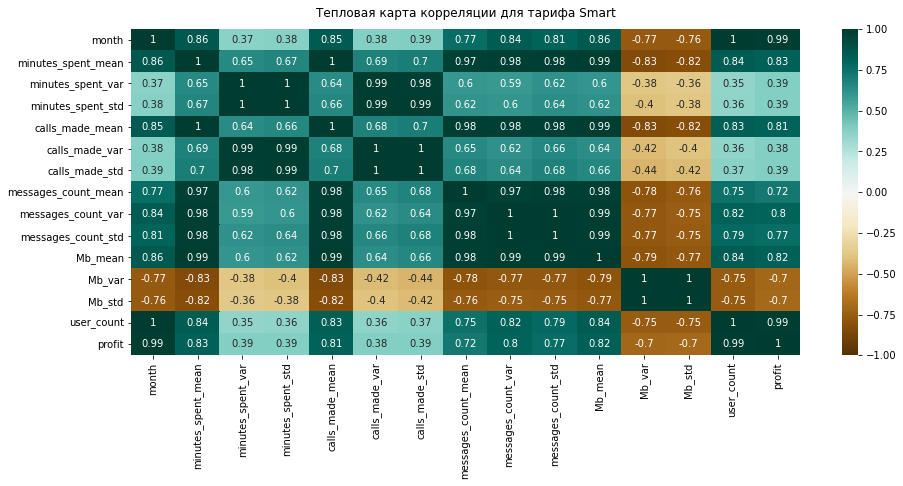

In [91]:
plt.figure(figsize=(15, 6))
heatmap = sns.heatmap(client_behaviour_tariff_smart.corr(), vmin=-1, vmax=1, annot=True, cmap='BrBG');
heatmap.set_title('Тепловая карта корреляции для тарифа Smart', fontdict={'fontsize':12}, pad=12);

Наблюдаются чёткие зависимости между :
- Месяцем и средним количеством минут, звонков, смс и Мб; 
- Средним количеством минут, звонков, смс и Мб;
- Общая прибыль больше всего зависит от месяца;
- Наблюдается чёткая обратная корреляция между средним/дисперсией количества Mb и всеми остальными значениями, то есть меньшим значениям среднего/дисперси соответствуют меньшие значения всех остальных параметров;

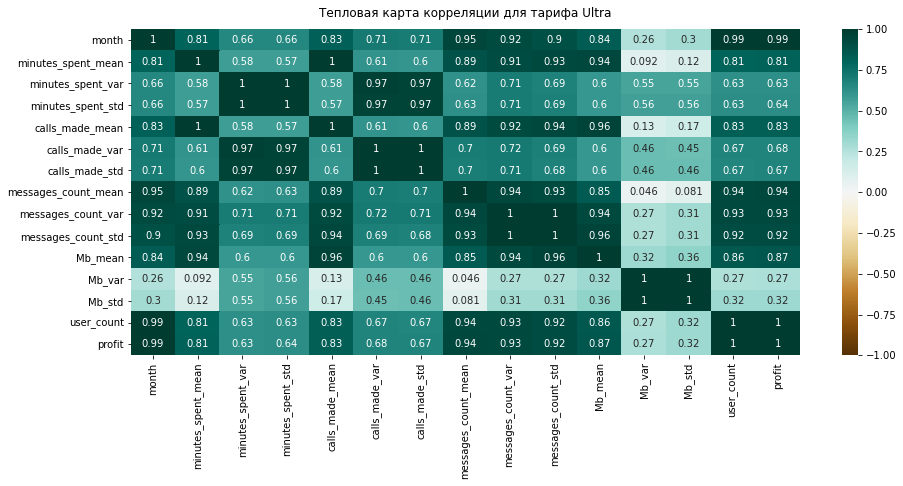

In [92]:
plt.figure(figsize=(15, 6))
heatmap = sns.heatmap(client_behaviour_tariff_ultra.corr(), vmin=-1, vmax=1, annot=True, cmap='BrBG');
heatmap.set_title('Тепловая карта корреляции для тарифа Ultra', fontdict={'fontsize':12}, pad=12);

Всё, что характерно для тарифа Smart, так же характерно и для тарифа Ultra, но с одним исключением:
- Уже не наблюдается чёткой обратной корреляции между средним/дисперсией количества Mb и всеми остальными значениями. 

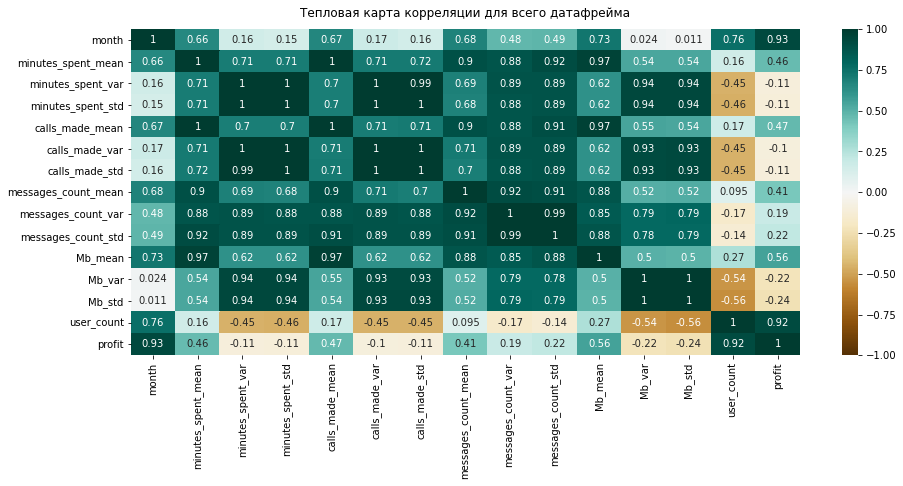

In [93]:
plt.figure(figsize=(15, 6))
heatmap = sns.heatmap(client_behaviour.corr(), vmin=-1, vmax=1, annot=True, cmap='BrBG');
heatmap.set_title('Тепловая карта корреляции для всего датафрейма', fontdict={'fontsize':12}, pad=12);

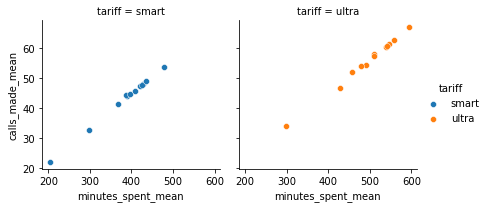

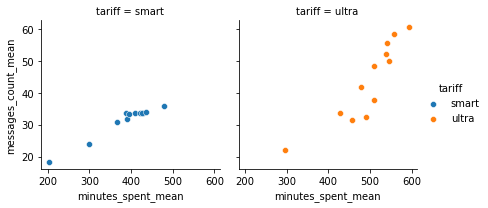

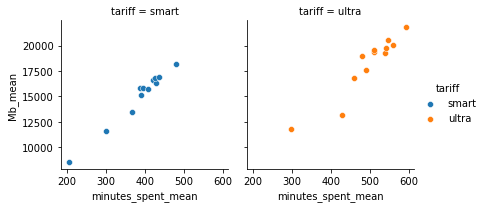

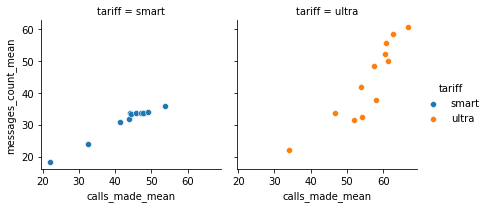

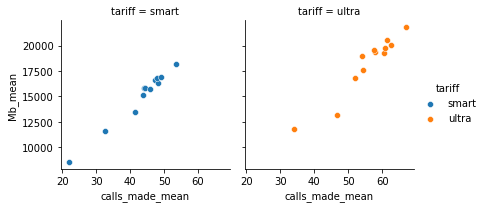

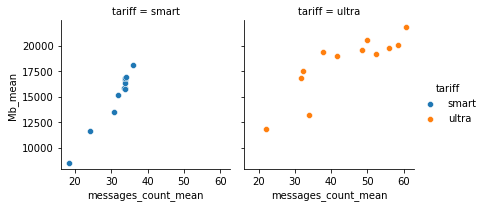

In [94]:
def Grids(row, row2):
    grid = sns.FacetGrid(client_behaviour, col="tariff", hue="tariff");
    grid.map(sns.scatterplot, row, row2);
    grid.add_legend();
    
Grids("minutes_spent_mean", "calls_made_mean")
Grids("minutes_spent_mean", "messages_count_mean")
Grids("minutes_spent_mean", "Mb_mean")
Grids("calls_made_mean", "messages_count_mean")
Grids("calls_made_mean", "Mb_mean")
Grids("messages_count_mean", "Mb_mean")

Подтверждаем вывод о чёткой линейной зависимости между средним количеством минут, звонков, смс и Мб.

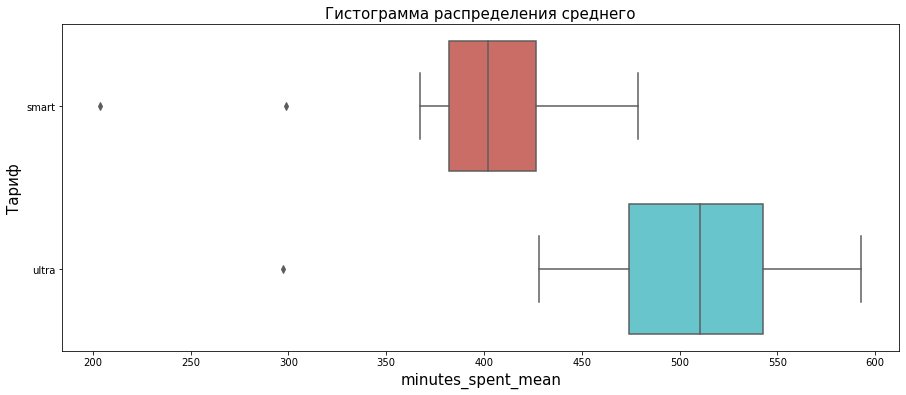

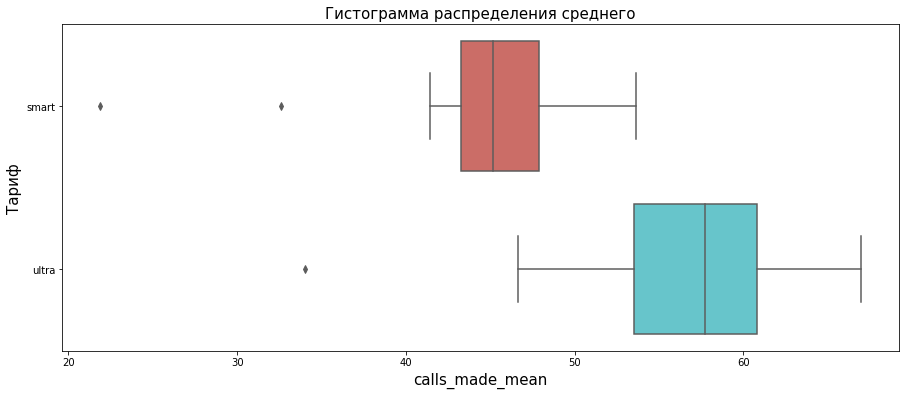

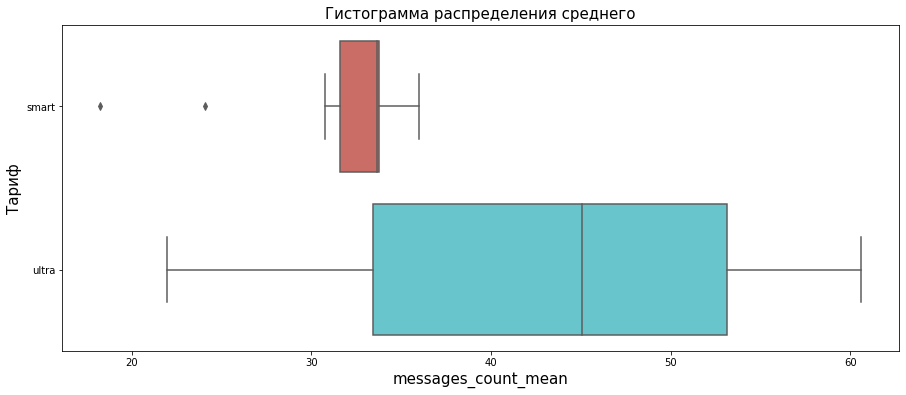

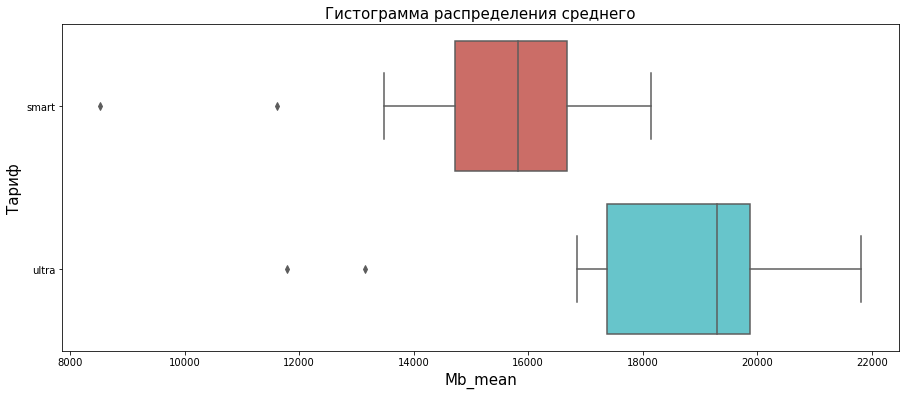

In [95]:
def Boxplots(row):
    for row in client_behaviour[['minutes_spent_mean', 'calls_made_mean', 'messages_count_mean', 'Mb_mean']]:
        plt.figure(figsize=(15,6));
        plt.title('Гистограмма распределения среднего', fontsize=15);
        sns.boxplot(x = row, y = 'tariff', data = client_behaviour, palette='hls');
        plt.ylabel('Тариф', fontsize = 15);
        plt.xlabel(row, fontsize = 15);
        
Boxplots(client_behaviour[['minutes_spent_mean', 'calls_made_mean', 'messages_count_mean', 'Mb_mean']])

Пользователи тарифа Smart:
- разговаривают около 400 минут;
- совершают в среднем около 43 звонков;
- отправляют около 30 сообщений;
- используют чуть меньше 15000 Mb.
- приносят прибыли в среднем 230000 ₽.

Пользователи тарифа Ultra:
- разговаривают около 520 минут;
- совершают в среднем 55 звонков;
- отправляют около 43 сообщений;
- используют чуть меньше 18000 Mb.
- приносят прибыли в среднем 170000 ₽.

Граничные значения для тарифа Smart:
- 50 сообщений;
- 15360 Mb;
- 500 минут.

Граничные значения для тарифа Ultra:
- 1000 сообщений;
- 30720 Mb;
- 3000 минут.

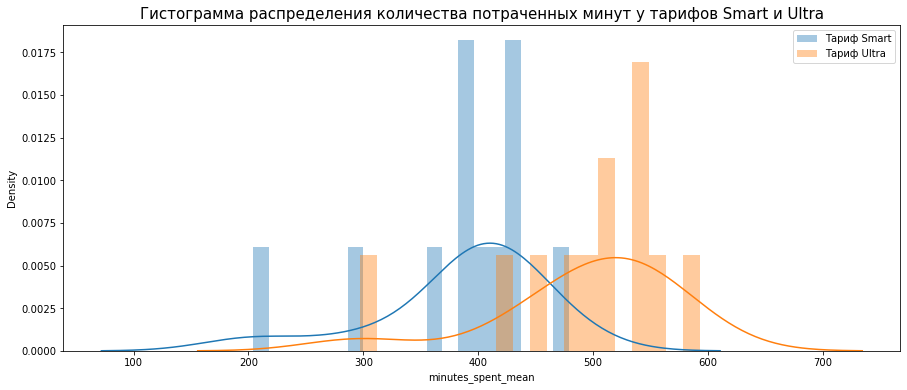

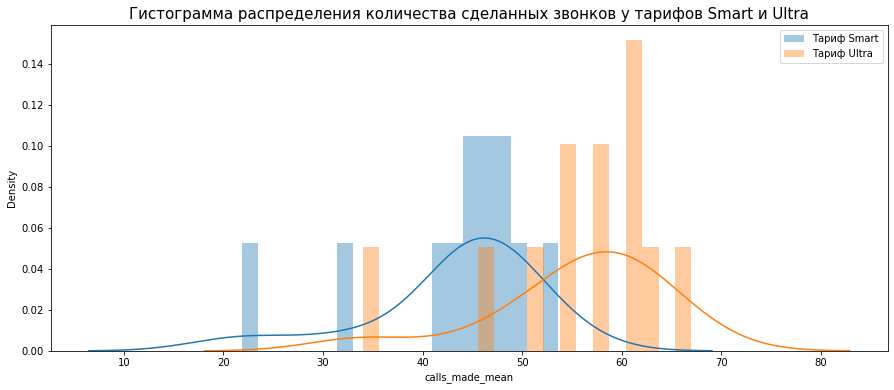

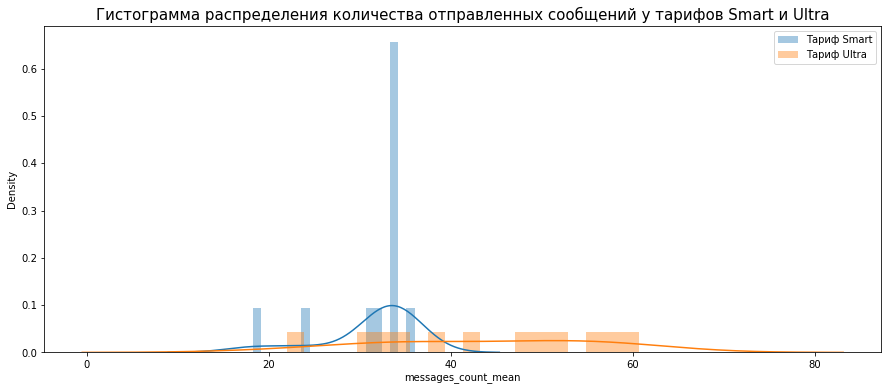

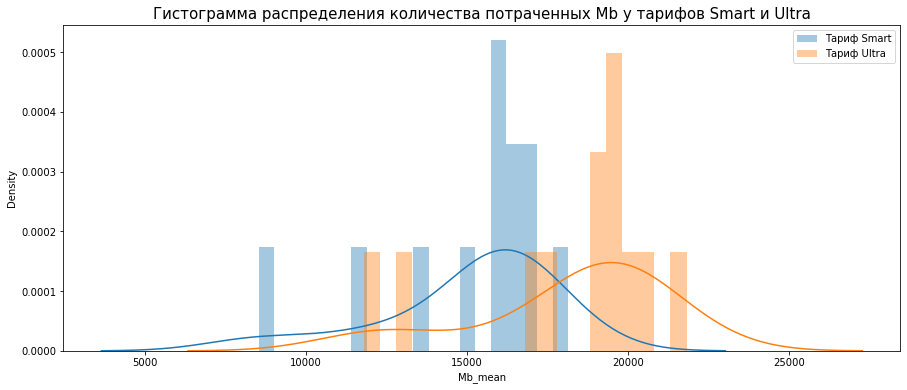

In [96]:
def Hists(row, title):
    plt.figure(figsize=(15,6))
    plt.title(title, fontsize=15)
    sns.distplot(client_behaviour_tariff_smart[row], bins = 20, label = 'Тариф Smart',)
    sns.distplot(client_behaviour_tariff_ultra[row], bins = 20, label = 'Тариф Ultra')
    plt.legend()

Hists('minutes_spent_mean', 'Гистограмма распределения количества потраченных минут у тарифов Smart и Ultra')
Hists('calls_made_mean', 'Гистограмма распределения количества сделанных звонков у тарифов Smart и Ultra')
Hists('messages_count_mean', 'Гистограмма распределения количества отправленных сообщений у тарифов Smart и Ultra')
Hists('Mb_mean', 'Гистограмма распределения количества потраченных Mb у тарифов Smart и Ultra')

Распределение у всех графиков для обоих тарифов нормальное с левым смещением.

In [97]:
data_all[((data_all['Mb_spent'] >= 15300) | (data_all['minutes_spent'] >= 500)) & (data_all['tariff'] == 'smart')]

,user_id,month,minutes_spent,calls_made,messages_count,month_name,Mb_spent,age,churn_date,city,...,reg_date,tariff,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,profit
985,1001,11,430,45,0,November,18452,41,NaT,Москва,...,2018-11-01,smart,50,15360,500,550,200,3,3,1153
988,1002,7,214,21,11,July,17601,59,NaT,Стерлитамак,...,2018-06-17,smart,50,15360,500,550,200,3,3,987
989,1002,8,289,37,13,August,20347,59,NaT,Стерлитамак,...,2018-06-17,smart,50,15360,500,550,200,3,3,1524
990,1002,9,206,25,4,September,16712,59,NaT,Стерлитамак,...,2018-06-17,smart,50,15360,500,550,200,3,3,814
992,1002,11,243,25,16,November,18610,59,NaT,Стерлитамак,...,2018-06-17,smart,50,15360,500,550,200,3,3,1184
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3207,1373,4,0,0,48,April,20399,34,NaT,Улан-Удэ,...,2018-01-17,smart,50,15360,500,550,200,3,3,1534
3210,1489,9,0,0,32,September,17232,35,NaT,Санкт-Петербург,...,2018-08-15,smart,50,15360,500,550,200,3,3,915
3211,1489,10,0,0,21,October,19588,35,NaT,Санкт-Петербург,...,2018-08-15,smart,50,15360,500,550,200,3,3,1375
3212,1489,11,0,0,20,November,17516,35,NaT,Санкт-Петербург,...,2018-08-15,smart,50,15360,500,550,200,3,3,971


In [98]:
data_all[((data_all['Mb_spent'] >= 32500) | (data_all['minutes_spent'] >= 3000)) & (data_all['tariff'] == 'ultra')]

,user_id,month,minutes_spent,calls_made,messages_count,month_name,Mb_spent,age,churn_date,city,...,reg_date,tariff,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,profit
50,1024,11,1146,127,0,November,43146,73,NaT,Санкт-Петербург,...,2018-10-31,ultra,1000,30720,3000,1950,150,1,1,3770
51,1024,12,949,108,0,December,35985,73,NaT,Санкт-Петербург,...,2018-10-31,ultra,1000,30720,3000,1950,150,1,1,2721
78,1050,7,209,26,52,July,35205,44,2018-10-03,Тюмень,...,2018-06-16,ultra,1000,30720,3000,1950,150,1,1,2606
97,1060,12,1233,144,52,December,43973,46,NaT,Калуга,...,2018-11-24,ultra,1000,30720,3000,1950,150,1,1,3891
211,1124,10,1225,130,121,October,49789,54,NaT,Махачкала,...,2018-09-24,ultra,1000,30720,3000,1950,150,1,1,4743
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
943,1495,9,813,95,82,September,33105,65,NaT,Иркутск,...,2018-08-28,ultra,1000,30720,3000,1950,150,1,1,2299
945,1495,11,954,112,79,November,38972,65,NaT,Иркутск,...,2018-08-28,ultra,1000,30720,3000,1950,150,1,1,3158
968,1231,9,0,0,188,September,33220,63,NaT,Чебоксары,...,2018-05-23,ultra,1000,30720,3000,1950,150,1,1,2316
976,1328,11,0,0,8,November,35567,44,NaT,Мурманск,...,2018-10-16,ultra,1000,30720,3000,1950,150,1,1,2660


## Вывод

Данные по таблицам тарифов:
- Количество пользователей тарифа Smart: 351
- Количество пользователей тарифа Ultra: 149
- Прибыль от тарифа Smart от одного пользователя: 7830 рублей
- Прибыль от тарифа Ultra от одного пользователя: 13621 рублей
- Прибыль от тарифа Smart: 2748486 рублей
- Прибыль от тарифа Ultra: 2029556 рублей

У тарифа Smart в 2 раза больше пользователей, при этом он генерирует всего на 40% больше прибыли; думаю, что нужно создать промежуточный тариф, который могут взять люди, которые выходят за рамки тарифа Smart, при правильном ценообразовании можно заработать.

В таблице тарифа Smart наблюдаются чёткие зависимости между :
- Месяцем и средним количеством минут, звонков, смс и Мб; 
- Средним количеством минут, звонков, смс и Мб;
- Общая прибыль больше всего зависит от месяца;
- Наблюдается чёткая обратная корреляция между средним/дисперсией количества Mb и всеми остальными значениями, то есть меньшим значениям среднего/дисперси соответствуют меньшие значения всех остальных параметров;

Всё, что характерно для тарифа Smart, так же характерно и для тарифа Ultra, но с одним исключением:
- Уже не наблюдается чёткой обратной корреляции между средним/дисперсией количества Mb и всеми остальными значениями. 

Пользователи тарифа Smart:
- разговаривают около 400 минут;
- совершают в среднем около 43 звонков;
- отправляют около 30 сообщений;
- используют чуть меньше 15000 Mb.
- приносят прибыли в среднем 230000 ₽.

Пользователи тарифа Ultra:
- разговаривают около 520 минут;
- совершают в среднем 55 звонков;
- отправляют около 43 сообщений;
- используют чуть меньше 18000 Mb.
- приносят прибыли в среднем 170000 ₽.

Граничные значения для тарифа Smart:
- 50 сообщений;
- 15360 Mb;
- 500 минут.

Граничные значения для тарифа Ultra:
- 1000 сообщений;
- 30720 Mb;
- 3000 минут.

Можно сказать, что если среднестатистический человек на тарифе Ultra будет чуть меньше разговаривать и чуть меньше пользоваться интернетом, то ему вполне хватит тарифа Smart. С учётом расценок даже если этот среднестатистический человек перейдёт на тариф Smart без изменения поведенческой схемы, то ему с учётом доплат(150 ₽ за гигабайт и 1 ₽ за каждую минуту) всё равно будет выгоднее (где-то на 500 ₽). 

Распределение у всех графиков гистограмм для обоих тарифов нормальное с левым смещением.

Можно заметить, что случаев, когда люди выходят за рамки тарифа Smart, почти в 15 раз больше, чем тех же случаев для тарифа Ultra. 

Сколько минут разговора, сколько сообщений и какой объём интернет-трафика требуется пользователям каждого тарифа в месяц?

для тарифа Smart требуется:
- олоко 400 минут разговоров;
- около 30 сообщений;
- чуть меньше 15000 Mb.

для тарифа Ultra требуется:
- ококо 520 минут разговоров;
- около 343 сообщений;
- чуть меньше 18000 Mb.

# Шаг 4. Проверьте гипотезы

## Средняя выручка пользователей тарифов «Ультра» и «Смарт» 

При формулировании нулевой гипотезы нужно всегда использовать знак равенства, поэтому я её формулирую так:
- Нулевая гипотеза H0 - средняя выручка пользователей тарифов «Ультра» и «Смарт» равна;
- Альтернативная гипотеза H1 будет говорить об обратном - средняя выручка пользователей тарифов «Ультра» и «Смарт» не равна.
Гипотезы получились двусторонними.

Теперь нам нужно посчитать средние значения для выручки от пользователей исходя из тарифа.

In [99]:
smart_profit = data_all[data_all['tariff'] == 'smart']['profit']
ultra_profit = data_all[data_all['tariff'] == 'ultra']['profit']

In [100]:
smart_profit

985     1153
986      550
987      550
988      987
989     1524
        ... 
3209     550
3210     915
3211    1375
3212     971
3213     936
Name: profit, Length: 2229, dtype: int32

In [101]:
stat, p = mannwhitneyu(smart_profit, ultra_profit)
print('Statistics=%.3f, p = %.3f' % (stat, p))

alpha = .05

if (p < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

Statistics=347821.000, p = 0.000
Отвергаем нулевую гипотезу


In [102]:
alpha = .05

results = st.ttest_ind(smart_profit, ultra_profit)# ваш код: проведите тест и посчитайте p-значение

print('p-значение:', results.pvalue)# ваш код: выведите на экран полученное p-значение)

if (results.pvalue < alpha):# ваш код: сравните p-значение с заданным критическим уровнем стат. значимости):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 8.2203157605818e-191
Отвергаем нулевую гипотезу


Чего и стоило ожидать: средняя выручка пользователей тарифов «Ультра» и «Смарт» различается.

## Cредняя выручка пользователей из Москвы и других регионов

Нулевая гипотеза H0 - средняя выручка пользователей из Москвы не отличается от выручки пользователей из других регионов;
Альтернативная гипотеза H1 - средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов. Гипотезы получились двусторонними.
Для начала посчитаем среднюю выручку исходя из города.

In [103]:
Moscow_profit = data_all[data_all['city'] == 'Москва']['profit']
Region_profit = data_all[data_all['city'] != 'Москва']['profit']

In [104]:
Moscow_profit

8       1950
9       1950
10      1950
11      1950
12      1950
        ... 
3166     927
3167     550
3168    1591
3169    1208
3170     637
Name: profit, Length: 611, dtype: int32

In [105]:
Region_profit

0       1950
1       1950
2       1950
3       1950
4       1950
        ... 
3209     550
3210     915
3211    1375
3212     971
3213     936
Name: profit, Length: 2603, dtype: int32

In [106]:
stat, p = mannwhitneyu(Moscow_profit, Region_profit)
print('Statistics=%.3f, p = %.3f' % (stat, p))

alpha = .05

if (p < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

Statistics=772892.500, p = 0.137
Не получилось отвергнуть нулевую гипотезу


In [107]:
alpha = .05

results = st.ttest_ind(Moscow_profit, Region_profit)# ваш код: проведите тест и посчитайте p-значение

print('p-значение:', results.pvalue)# ваш код: выведите на экран полученное p-значение)

if (results.pvalue < alpha):# ваш код: сравните p-значение с заданным критическим уровнем стат. значимости):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.4741107329003996
Не получилось отвергнуть нулевую гипотезу


Значит прибыль не зависит от города и примерно равна по всей стране.

# Шаг 5. Общий вывод

пользователи тарифа Smart в среднем используют:
- олоко 400 минут разговоров;
- около 30 сообщений;
- чуть меньше 15000 Mb.

пользователи тарифа Ultra в среднем используют:
- ококо 520 минут разговоров;
- около 343 сообщений;
- чуть меньше 18000 Mb.

Cредняя выручка пользователей тарифов «Ультра» и «Смарт» различается.

Прибыль не зависит от города и примерно равна по всей стране.

Напрашивается решение с переделыванием лимитов и добавлением нового тарифа между Smart и Ultra: 
1) тариф Smart можно порезать по всем параметрам, чтобы в него влезал среднестатистический пользователь;
- олоко 400 минут разговоров;
- около 30 сообщений;
- меньше 15000 Mb.
2) сделать тарифом Medium 
- олоко 450 минут разговоров;
- около 35 сообщений;
- около 16500 Mb.
3) тариф Ultra можно оставить, как есть.

Интересно, что из этого бы вышло.

## Чек-лист готовности проекта

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

Шаг 1. Откройте файл с данными и изучите общую информацию
- [x]  открыт файл;
- [x]  файл изучен;

Шаг 2. Подготовьте данные

- [x]  определены пропущенные значения;
- [x]  есть пояснение, какие пропущенные значения обнаружены;
- [x]  описаны возможные причины появления пропусков в данных;
- [x]  объяснено, по какому принципу заполнены/не заполнены пропуски;
- [x]  есть пояснение, какой метод используется для изменения типа данных и почему;

Посчитайте для каждого пользователя:

- [x]  количество сделанных звонков и израсходованных минут разговора по месяцам;
- [x]  количество отправленных сообщений по месяцам;
- [x]  объем израсходованного интернет-трафика по месяцам;
- [x]  помесячную выручку с каждого пользователя (вычтите бесплатный лимит из суммарного количества звонков, сообщений и интернет-трафика; остаток умножьте на значение из тарифного плана; прибавьте абонентскую плату, соответствующую тарифному плану).

Шаг 3. Проанализируйте данные 

- [x]  Опишите поведение клиентов оператора, исходя из выборки. 
- [x]  Сколько минут разговора, сколько сообщений и какой объём интернет-трафика требуется пользователям каждого тарифа в месяц? Посчитайте среднее количество, дисперсию и стандартное отклонение. 
- [x]  Постройте гистограммы. 
- [x]  Опишите распределения.

Шаг 4. Проверьте гипотезы

- [x]  средняя выручка пользователей тарифов «Ультра» и «Смарт» различается;
- [x]  средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов;
- [x]  Поясните, как вы формулировали нулевую и альтернативную гипотезы;
- [x]  Поясните, какой критерий использовали для проверки гипотез и почему.